In [75]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

sys.path.append(os.path.join('../', 'utils'))

from TransformationUtils import ExcelYAMLHandler, StrategyCSVHandler
from GeneralUtils import GeneralUtils

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [77]:
g_utils = GeneralUtils()

In [78]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_project = dir_cur.parent
dir_data = dir_cur.joinpath("data")
dir_config = dir_cur.joinpath("config_files")
dir_transformations = dir_cur.joinpath("transformations")
dir_utils = dir_project.joinpath("utils")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_utils.joinpath("strategy_mapping.yaml")

In [79]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "georgia_config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']


Country Name: georgia
SSP Input File Name: sisepuede_inputs_georgia.csv
SSP Transformation CW: ssp_georgia_transformation_cw.xlsx


In [80]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [81]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [82]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [83]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df1(example) but not in df2(yours): set()
Columns in df2(yours) but not in df1(example): {'Unnamed: 0'}


In [84]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

No missing columns to add.


,Unnamed: 0,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,0,georgia,0,6970000,70,2923,31.751466,6468,315,508,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,1,georgia,1,6970000,70,2923,31.751466,6468,315,508,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,2,georgia,2,6970000,70,2923,31.751466,6468,315,508,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,3,georgia,3,6970000,70,2923,31.751466,6468,315,508,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,4,georgia,4,6970000,70,2923,31.751466,6468,315,508,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [85]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df1(example) but not in df2(yours): set()
Columns in df2(yours) but not in df1(example): {'Unnamed: 0'}


In [86]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


In [87]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    georgia
1    georgia
2    georgia
3    georgia
4    georgia
Name: region, dtype: object

In [88]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    georgia
1    georgia
2    georgia
3    georgia
4    georgia
Name: region, dtype: object

#  Let's try building transformations using this


In [89]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [90]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/fabian_fuentes/repos/sisepuede_region_nbs_tony_ver/georgia/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [91]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_data, ssp_transformation_cw)
excel_yaml_handler = ExcelYAMLHandler(excel_file=cw_file_path, yaml_directory='transformations')

In [92]:
# This creates transformation yaml files for each strategy in the excel file

# Use if its the first time you are running this
excel_yaml_handler.process_yaml_files()

# Use if you have already created the yaml files and just want to update them so the transformations with multiple params are not overwritten
# NOTE: This is a temporary solution, we need to find a better way to handle this
#excel_yaml_handler.process_yaml_files(overwrite_mult_param_transformations=False)

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC_Uncon set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC_2_scenario set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC_1_scenario set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_net_zero set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_NDC_Uncon set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strat

In [93]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC_Uncon': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC_UNCON',
  'TX:AGRC:DEC_EXPORTS_STRATEGY_NDC_UNCON',
  'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_NDC_UNCON',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC_UNCON',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC_UNCON',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC_UNCON',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC_UNCON',
  'TX:FGTV:DEC_LEAKS_STRATEGY_NDC_UNCON',
  'TX:FGTV:INC_FLARE_STRATEGY_NDC_UNCON',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC_UNCON',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC_UNCON',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC_UNCON',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC_UNCON',
  'TX:LNDU:INC_SILVOPASTURE_STRATEGY_NDC_UNCON',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC_UNCON',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC_UNCON',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC_UNCON',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC_UNCON',
  'TX:LVST:DEC_EXPORTS_STRATEGY_NDC_UNCON',
  'TX:LVST:INC_PROD

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [94]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

# Uncomment for completly new strategies version
csv_handler.add_strategy(strategy_group='PFLO', description='NDC Unconditional', yaml_file_suffix='NDC_2_scenario')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC 2 deg. Scenario', yaml_file_suffix='NDC_1_scenario')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC 1.5 deg. Scenario', yaml_file_suffix='net_zero')

Error: strategy_code PFLO:NDC_2_SCENARIO already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:NDC_1_SCENARIO already exists. Please use a different code or eliminate the existing one.
Error: strategy_code PFLO:NET_ZERO already exists. Please use a different code or eliminate the existing one.


In [95]:
# Uncomment to update the strategies that are currently in the strategy_definitions file

csv_handler.add_strategy(strategy_group='PFLO', description='NDC Unconditional', yaml_file_suffix='NDC_2_scenario', custom_id=6003, update_flag=True)
csv_handler.add_strategy(strategy_group='PFLO', description='NDC 2 deg. Scenario', yaml_file_suffix='NDC_1_scenario', custom_id=6004, update_flag=True)
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='net_zero', custom_id=6005, update_flag=True)

Data saved to /home/fabian_fuentes/repos/sisepuede_region_nbs_tony_ver/georgia/transformations/strategy_definitions.csv
Updated row with strategy_id 6003
Data saved to /home/fabian_fuentes/repos/sisepuede_region_nbs_tony_ver/georgia/transformations/strategy_definitions.csv
Updated row with strategy_id 6004
Data saved to /home/fabian_fuentes/repos/sisepuede_region_nbs_tony_ver/georgia/transformations/strategy_definitions.csv
Updated row with strategy_id 6005


In [96]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

### We finished adding new transformation files and strategies so lets load them back

In [97]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [98]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/sisepuede_region_nbs_tony_ver/georgia/transformations initialized in 3.21 seconds


In [99]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC_2_SCENARIO,NDC_2_scenario,NDC Unconditional,TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC_2_SCENAR...,0
70,6004,PFLO:NDC_1_SCENARIO,NDC_1_scenario,NDC 2 deg. Scenario,TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC_1_SCENAR...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [100]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [101]:
country_name

'georgia'

In [102]:
# Make sure to change the regions attribute to your country name

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-01-23 18:44:28,187 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-01-23 18:44:28,187 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-01-23 18:44:28,191 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-01-23 18:44:28,191 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-01-23 18:44:28,192 - INFO - 	Setting export engine to 'csv'.
2025-01-23 18:44:28,192 - INFO - 	Setting export engine to 'csv'.
2025-01-23 18:44:28,193 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-01-23 18:44:28,193 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-01-23 18:44:28,193 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-01-23 18:44:28,193 - INFO - Successfully

In [103]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2025-01-23 18:44:50,150 - INFO - 
***	STARTING REGION georgia	***

2025-01-23 18:44:50,150 - INFO - 
***	STARTING REGION georgia	***

2025-01-23 18:44:52,796 - INFO - Trying run primary_id = 0 in region georgia
2025-01-23 18:44:52,796 - INFO - Trying run primary_id = 0 in region georgia
2025-01-23 18:44:52,798 - INFO - Running AFOLU model
2025-01-23 18:44:52,798 - INFO - Running AFOLU model
2025-01-23 18:44:52,933 - INFO - AFOLU model run successfully completed
2025-01-23 18:44:52,933 - INFO - AFOLU model run successfully completed
2025-01-23 18:44:52,934 - INFO - Running CircularEconomy model
2025-01-23 18:44:52,934 - INFO - Running CircularEconomy model
2025-01-23 18:44:52,981 - INFO - CircularEconomy model run successfully completed
2025-01-23 18:44:52,981 - INFO - CircularEconomy model run successfully completed
2025-01-23 18:44:52,982 - INFO - Running IPPU model
2025-01-23 18:44:52,982 - INFO - Running IPPU model
2025-01-23 18:44:53,055 - INFO - IPPU model run successfully complet

2025-23-Jan 18:44:53.191 Opened SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-23-Jan 18:44:53.215 Added NEMO structure to SQLite database at /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-23-Jan 18:44:54.532 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-23 18:46:53,264 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:46:53,264 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:46:53,275 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:46:53,275 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:46:53,277 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:46:53,277 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:46:53,321 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:46:53,321 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:46:53,322 - INFO - Appending Socioeconomic outputs
2025-01-23 18:46:53,322 - INFO - Appending Socioec

2025-23-Jan 18:46:53.125 Finished modeling scenario.


2025-01-23 18:46:53,338 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:46:53,338 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:46:53,341 - INFO - Model run for primary_id = 0 successfully completed in 120.54 seconds (n_tries = 1).
2025-01-23 18:46:53,341 - INFO - Model run for primary_id = 0 successfully completed in 120.54 seconds (n_tries = 1).
2025-01-23 18:46:53,360 - INFO - Trying run primary_id = 69069 in region georgia
2025-01-23 18:46:53,360 - INFO - Trying run primary_id = 69069 in region georgia
2025-01-23 18:46:53,361 - INFO - Running AFOLU model
2025-01-23 18:46:53,361 - INFO - Running AFOLU model
2025-01-23 18:46:53,502 - INFO - AFOLU model run successfully completed
2025-01-23 18:46:53,502 - INFO - AFOLU model run successfully completed
2025-01-23 18:46:53,503 - INFO - Running CircularEconomy model
2025-01-23 18:46:53,503 - INFO - Running CircularEconomy model
2025-01-23 18:46:53,552 - INFO - CircularEconomy model run successfull

2025-23-Jan 18:46:54.840 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-23 18:48:06,144 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:48:06,144 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:48:06,155 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:48:06,155 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:48:06,156 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:48:06,156 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:48:06,198 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:48:06,198 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:48:06,199 - INFO - Appending Socioeconomic outputs
2025-01-23 18:48:06,199 - INFO - Appending Socioec

2025-23-Jan 18:48:05.995 Finished modeling scenario.


2025-01-23 18:48:06,220 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:48:06,220 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:48:06,225 - INFO - Model run for primary_id = 69069 successfully completed in 72.86 seconds (n_tries = 1).
2025-01-23 18:48:06,225 - INFO - Model run for primary_id = 69069 successfully completed in 72.86 seconds (n_tries = 1).
2025-01-23 18:48:06,232 - INFO - Trying run primary_id = 70070 in region georgia
2025-01-23 18:48:06,232 - INFO - Trying run primary_id = 70070 in region georgia
2025-01-23 18:48:06,234 - INFO - Running AFOLU model
2025-01-23 18:48:06,234 - INFO - Running AFOLU model
2025-01-23 18:48:06,369 - INFO - AFOLU model run successfully completed
2025-01-23 18:48:06,369 - INFO - AFOLU model run successfully completed
2025-01-23 18:48:06,370 - INFO - Running CircularEconomy model
2025-01-23 18:48:06,370 - INFO - Running CircularEconomy model
2025-01-23 18:48:06,421 - INFO - CircularEconomy model run succe

2025-23-Jan 18:48:07.697 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-23 18:49:51,988 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:49:51,988 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:49:52,000 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:49:52,000 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:49:52,001 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:49:52,001 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:49:52,047 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:49:52,047 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:49:52,048 - INFO - Appending Socioeconomic outputs
2025-01-23 18:49:52,048 - INFO - Appending Socioec

2025-23-Jan 18:49:51.852 Finished modeling scenario.


2025-01-23 18:49:52,065 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:49:52,065 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:49:52,068 - INFO - Model run for primary_id = 70070 successfully completed in 105.83 seconds (n_tries = 1).
2025-01-23 18:49:52,068 - INFO - Model run for primary_id = 70070 successfully completed in 105.83 seconds (n_tries = 1).
2025-01-23 18:49:52,075 - INFO - Trying run primary_id = 71071 in region georgia
2025-01-23 18:49:52,075 - INFO - Trying run primary_id = 71071 in region georgia
2025-01-23 18:49:52,076 - INFO - Running AFOLU model
2025-01-23 18:49:52,076 - INFO - Running AFOLU model
2025-01-23 18:49:52,214 - INFO - AFOLU model run successfully completed
2025-01-23 18:49:52,214 - INFO - AFOLU model run successfully completed
2025-01-23 18:49:52,215 - INFO - Running CircularEconomy model
2025-01-23 18:49:52,215 - INFO - Running CircularEconomy model
2025-01-23 18:49:52,259 - INFO - CircularEconomy model run suc

2025-23-Jan 18:49:54.090 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-01-23 18:51:11,157 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:51:11,157 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-01-23 18:51:11,168 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:51:11,168 - INFO - EnergyProduction model run successfully completed
2025-01-23 18:51:11,168 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:51:11,168 - INFO - Running Energy (Fugitive Emissions)
2025-01-23 18:51:11,210 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:51:11,210 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-01-23 18:51:11,211 - INFO - Appending Socioeconomic outputs
2025-01-23 18:51:11,211 - INFO - Appending Socioec

2025-23-Jan 18:51:11.023 Finished modeling scenario.


2025-01-23 18:51:11,228 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:51:11,228 - INFO - Socioeconomic outputs successfully appended.
2025-01-23 18:51:11,231 - INFO - Model run for primary_id = 71071 successfully completed in 79.16 seconds (n_tries = 1).
2025-01-23 18:51:11,231 - INFO - Model run for primary_id = 71071 successfully completed in 79.16 seconds (n_tries = 1).
2025-01-23 18:51:11,233 - INFO - 
***	 REGION georgia COMPLETE	***

2025-01-23 18:51:11,233 - INFO - 
***	 REGION georgia COMPLETE	***

2025-01-23 18:51:11,330 - INFO - Table MODEL_OUTPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-01-23T18;44;27.728883/sisepuede_run_2025-01-23T18;44;27.728883_output_database/MODEL_OUTPUT.csv.
2025-01-23 18:51:11,330 - INFO - Table MODEL_OUTPUT successfully written to /home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-01-23T18;44;2

{'georgia': [0, 69069, 70070, 71071]}

In [29]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [104]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [105]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,georgia,0,68043.892566,151354.043079,31404.873492,81856.221185,105627.965703,57648.297868,76258.593271,...,1.166552e+06,2.910869e+06,53111.993547,62028.324081,0.0,115873.824581,80053.907854,1.846732e+06,486067.626197,289499.051145
1,0,georgia,1,68038.488033,151342.021458,31402.379092,81849.719578,105619.575974,57643.719028,76252.536268,...,1.048334e+06,2.910638e+06,52936.213643,62233.532181,1108.0,115864.621052,80047.549399,2.228581e+06,467516.919002,274562.894120
2,0,georgia,2,68086.083016,151447.889786,31424.346007,81906.975936,105693.460067,57684.042555,76305.877226,...,1.034004e+06,2.918278e+06,52846.072734,62655.573713,1108.0,115945.671864,80114.225557,2.383097e+06,464501.090903,272884.874166
3,0,georgia,3,68101.985288,151483.262148,31431.685518,81926.106234,105718.145966,57697.515314,76323.699324,...,1.068133e+06,3.496025e+06,52998.336736,62350.504596,1108.0,115972.752283,91846.810698,2.469998e+06,513293.540909,267772.543460
4,0,georgia,4,68085.153665,151445.822575,31423.917076,81905.857934,105692.017388,57683.255188,76304.835678,...,8.799564e+05,2.912634e+06,52934.370165,62419.206053,1108.0,115944.089247,100728.833012,2.360005e+06,417496.736540,250346.822286


In [106]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
0,0.879017,0.0,3.594728,0.101022,-1.511892,2.252699,2.684262,0.236636,1.242153,4.112320,...,0.621589,0.000670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.878549,0.0,3.757613,0.104411,-1.552889,2.233998,2.687567,0.227265,1.241380,4.109179,...,0.679162,0.000479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.879395,0.0,1.484019,0.043892,-1.594720,2.236988,2.702832,0.267529,1.241063,4.107724,...,0.742636,0.000519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.882487,0.0,4.082315,0.116025,-1.635478,2.352835,2.669632,0.203780,1.240671,4.106135,...,0.810475,0.000524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.878681,0.0,3.626973,0.110496,-1.674350,2.270284,2.616090,0.236116,1.240331,4.104914,...,0.879297,0.000445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
139,0.829573,-1.284131,0.181227,0.002132,-2.575869,0.224513,1.011148,0.211421,0.783316,4.178509,...,9.892439,0.000692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0.825546,-1.351717,0.170525,0.001466,-2.566343,0.168699,0.884025,0.212336,0.724141,4.099657,...,10.349715,0.000697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0.821521,-1.419303,0.160370,0.000923,-2.553899,0.116614,0.756892,0.213244,0.662563,4.014943,...,10.794779,0.000702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,0.817498,-1.486889,0.174758,0.000498,-2.538541,0.068106,0.630073,0.214145,0.598769,3.924714,...,11.223393,0.000707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.813478,-1.554475,0.161952,0.000174,-2.520298,0.023043,0.503937,0.215039,0.536480,3.854973,...,11.633383,0.000710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,1.241355e+06,2015
1,0,1,1.243857e+06,2016
2,0,2,1.246277e+06,2017
3,0,3,1.248623e+06,2018
4,0,4,1.250897e+06,2019
5,0,5,1.253105e+06,2020
6,0,6,1.256709e+06,2021
7,0,7,1.260150e+06,2022
8,0,8,1.263442e+06,2023
9,0,9,1.267572e+06,2024


In [109]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,1.012641e+07,2015
1,0,1,1.030557e+07,2016
2,0,2,1.048166e+07,2017
3,0,3,1.065485e+07,2018
4,0,4,1.082526e+07,2019
5,0,5,1.099303e+07,2020
6,0,6,1.127063e+07,2021
7,0,7,1.154156e+07,2022
8,0,8,1.180628e+07,2023
9,0,9,1.214516e+07,2024


In [110]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

In [111]:
df_in['lndu_reallocation_factor'].mean()

0.0

In [112]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    0.056947
1    0.056947
2    0.056947
3    0.056947
4    0.056947
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [113]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,0.056947
1,0,1,0.056947
2,0,2,0.056947
3,0,3,0.056947
4,0,4,0.056947


In [114]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [115]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,24245.432021,1.092435e+06,1.160868e+06,0.0,60550.410015,46225.393190,0.0,215420.506265,1.078050e+06
1,0,1,24201.909502,1.090434e+06,1.165539e+06,0.0,60857.232998,46460.268758,0.0,216288.026330,1.083502e+06
2,0,2,24136.887598,1.087538e+06,1.169042e+06,0.0,61101.921334,46645.554466,0.0,216938.111730,1.087853e+06
3,0,3,24052.890061,1.083723e+06,1.171362e+06,0.0,61283.025779,46785.429269,0.0,217368.106688,1.091092e+06
4,0,4,23932.465007,1.078339e+06,1.171951e+06,0.0,61375.952372,46856.135104,0.0,217478.151909,1.092732e+06
5,0,5,23849.467470,1.074567e+06,1.173545e+06,0.0,61514.617639,46960.925423,0.0,217772.636822,1.095201e+06
6,0,6,23712.852410,1.068408e+06,1.177490e+06,0.0,61825.339112,47198.516813,0.0,218505.865435,1.100751e+06
7,0,7,23558.523591,1.061465e+06,1.179962e+06,0.0,62056.930972,47375.012967,0.0,218963.980994,1.104859e+06
8,0,8,23387.742890,1.053768e+06,1.181030e+06,0.0,62210.842464,47493.129706,0.0,219162.262393,1.107592e+06
9,0,9,23263.008460,1.048156e+06,1.186331e+06,0.0,62607.442292,47797.532153,0.0,220146.357830,1.114681e+06


In [116]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,19299,969999,969999,6658,53699,40139,99,169699,865899
1,0,1,19285,969251,969251,6658,53658,40109,99,170377,865231
2,0,2,19278,968903,968903,6658,53639,40094,99,170885,864920
3,0,3,19270,968525,968525,6658,53618,40079,99,171221,864583
4,0,4,19264,968236,968236,6658,53602,40067,99,171307,864325
5,0,5,19256,967796,967796,6658,53578,40048,99,171537,863932
6,0,6,19247,967356,967356,6658,53553,40030,99,172110,863540
7,0,7,19238,966917,966916,6658,53529,40012,99,172468,863147
8,0,8,19229,966477,966477,6658,53505,39994,99,172623,862755
9,0,9,19221,966038,966038,6658,53480,39976,99,173392,862363


In [117]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.1950
1      0.1925
2      0.1900
3      0.1875
4      0.1850
        ...  
139    0.1175
140    0.1150
141    0.1125
142    0.1100
143    0.1075
Name: elasticity_protein_in_diet_to_gdppc, Length: 144, dtype: float64

In [118]:
df_in['frac_gnrl_eating_red_meat']

0      1.00
1      0.99
2      0.98
3      0.97
4      0.96
       ... 
139    0.70
140    0.70
141    0.70
142    0.70
143    0.70
Name: frac_gnrl_eating_red_meat, Length: 144, dtype: float64

In [119]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,19170.0,869500.0,869500.0,9298.0,49700.0,40480.0,95.0,155500.0,841900.0
41,5,19170.0,869500.0,869500.0,9298.0,49700.0,40480.0,95.0,155500.0,841900.0
77,5,19170.0,869500.0,869500.0,9298.0,49700.0,40480.0,95.0,155500.0,841900.0
113,5,19170.0,869500.0,869500.0,9298.0,49700.0,40480.0,95.0,155500.0,841900.0


In [120]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.241482,0.0,0.758518
1,0.241482,0.0,0.758518
2,0.241482,0.0,0.758518
3,0.241482,0.0,0.758518
4,0.241482,0.0,0.758518


In [121]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,506716.958185,733332.708004,27057.921077,45096.535129,32962.822857,32962.822857,306656.438875,27057.921077,24042.800814,44339.709967,28861.782482,32663.813770,129977.844976
1,523499.787396,736881.706911,27215.293372,45358.822287,33016.944557,33016.944557,309400.031364,27215.293372,24182.636788,44624.628812,28909.170680,32751.531057,130326.894968
2,540267.308832,740050.691195,27357.899909,45596.499849,33055.081902,33055.081902,311969.160541,27357.899909,24309.352383,44885.575765,28942.563200,32822.808159,130610.525168
3,557017.540448,742801.719460,27484.430527,45807.384212,33075.337097,33075.337097,314350.793296,27484.430527,24421.783431,45120.281572,28960.298363,32875.844279,130821.569739
4,573724.122786,744610.479855,27576.259930,45960.433216,33052.081144,33052.081144,316354.572172,27576.259930,24503.380093,45300.350103,28939.935779,32885.968236,130861.855607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,302762.822090,14074.602338,911.218253,1518.697088,5385.399138,5385.399138,11723.506131,911.218253,809.679313,2219.720073,820.065997,968.461913,4797.852557
140,233425.179240,8077.470778,512.926866,854.878111,4026.074249,4026.074249,6618.614342,512.926866,455.770362,1392.976781,459.805277,543.544737,2906.577955
141,159771.349258,3880.174764,228.069825,380.116375,2675.111051,2675.111051,2951.264219,228.069825,202.655531,747.035079,203.677346,240.999175,1478.326917
142,81914.274548,1261.176346,57.027936,95.046560,1332.949527,1332.949527,739.958929,57.027936,50.673195,282.681075,50.743991,60.096955,510.480502


In [122]:
df_qty_open_dump.head(15).sum(axis=1)

0     1.971730e+06
1     1.996400e+06
2     2.020280e+06
3     2.043297e+06
4     2.064398e+06
5     2.088496e+06
6     2.117918e+06
7     2.146890e+06
8     2.175388e+06
9     2.214938e+06
10    2.258631e+06
11    2.299063e+06
12    2.342244e+06
13    2.388507e+06
14    2.436496e+06
dtype: float64

In [123]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne


In [124]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414
1,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414
2,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414
3,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414
4,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414,0.124414
...,...,...,...,...,...,...,...
139,0.847724,0.847724,0.847724,0.847724,0.847724,0.847724,0.847724
140,0.885793,0.885793,0.885793,0.885793,0.885793,0.885793,0.885793
141,0.923862,0.923862,0.923862,0.923862,0.923862,0.923862,0.923862
142,0.961931,0.961931,0.961931,0.961931,0.961931,0.961931,0.961931


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [51]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

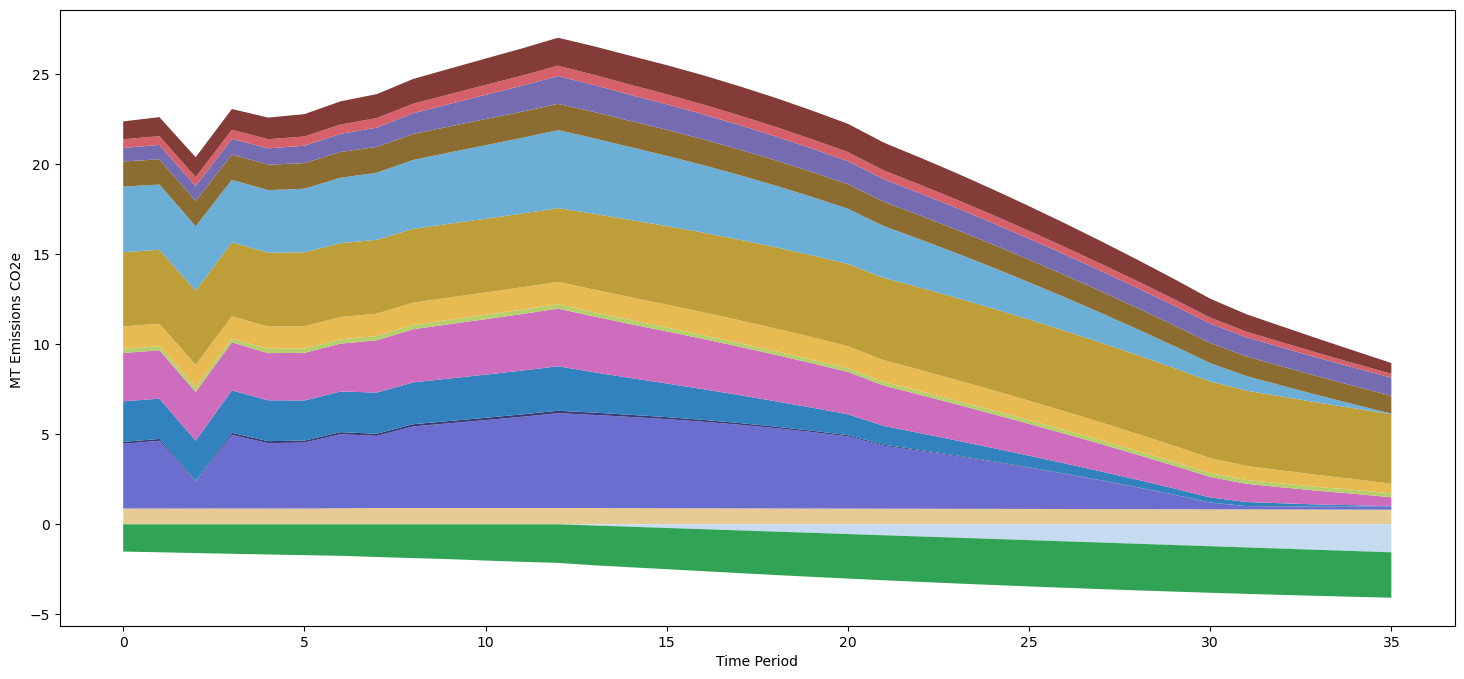

In [125]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [126]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [127]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [56]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [57]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [58]:
# df_resid

In [59]:
# [x for x in df_out.columns if "capacity" in x]

In [60]:
# ssp.model_attributes.configuration.dict_config


In [61]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [62]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [63]:
# df_inputs

In [64]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )